## A/B Test Results Analysis

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)  

<a id='intro'></a>
### Introduction

For this project, I will be working on the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [76]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [78]:
df=pd.read_csv("ab_data.csv")

In [80]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Number of rows and columns in the dataset

In [82]:
df.shape

(294478, 5)

Finding number of unique users in the dataset

In [84]:
len(df.user_id.unique())

290584

In [86]:
df.converted.mean()

0.11965919355605512

What is the number of times the `new_page` and `treatment` don't match?

In [88]:
df.shape[0]-len(df[((df['group'] != 'treatment') != (df['landing_page'] != 'new_page')) == False])

3893

Finding if any of the rows have missing values

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where "treatment" does not match with "new_page" or "control" does not match with "old_page", we cannot be sure if this row truly received the new or old page

In [92]:
# creating a new dataset that meets the specifications
df2 = df.drop(df[(df.group =="control") & (df.landing_page != "old_page")|(df.group =="treatment") & (df.landing_page != "new_page")].index)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [94]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

 How many unique `user_ids` are in df2?

In [96]:
len(df2.user_id.unique())

290584

In [98]:
# Checking if There is one user_id repeated in df2.
#source: https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,1,0,1
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,1,0,1


##### The duplicated user id is 773192, in rows 1899 and 2893.

In [100]:
# Removing one of the rows with a duplicate user_id, but keeping dataframe as df2
df2.drop(index=2893,inplace=True)

In [102]:
## to verify that the column is dropped
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   intercept     290584 non-null  int64 
 6   control       290584 non-null  uint8 
 7   ab_page       290584 non-null  uint8 
dtypes: int64(3), object(3), uint8(2)
memory usage: 16.1+ MB


<a id='probability'></a>
#### Part I - Probability  
What is the probability of an individual converting regardless of the page they receive?

In [104]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [106]:
df2.query('group=="control"').converted.mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [108]:
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

What is the probability that an individual received the new page?

In [110]:
df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]

0.5000619442226688

There's no sufficient evidences that the new treatment page did better than the old control page.
11.88% of people who used the new page converted, while 12% of people who used the old page converted.
it actually looks like the new page is doing worse.

<a id='ab_test'></a>
### Part II - A/B Test

Null hypothesis: the conversion rate due to the new page is worse or equal to the coversion rate due to the old page. 

**$p_{new}$**<=**$p_{old}$**

Alternative hypothesis: the conversion rate due to the new page is better than the conversion rate due to the old page. 

**$p_{new}$**>**$p_{old}$**

Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page.  

Using a sample size for each page equal to the ones in **ab_data.csv**, and Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  

The cells below provide the necessary parts of this simulation.  <br><br>

What is the **conversion rate** for $p_{new}$ under the null? 

In [112]:
p_new=df2.converted.mean()
p_new

0.11959708724499628

What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [114]:
p_old=df2.converted.mean()
p_old

0.11959708724499628

What is $n_{new}$, the number of individuals in the treatment group?

In [115]:
n_new=df2.query('group=="treatment"').shape[0]
n_new

145310

What is $n_{old}$, the number of individuals in the control group?

In [116]:
n_old=df2.query('group=="control"').shape[0]
n_old

145274

Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [117]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])

In [118]:
new_page_converted.mean()

0.11899387516344367

Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [119]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])

In [120]:
old_page_converted.mean()

0.11994575767171001

Finding $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [121]:
new_page_converted.mean()-old_page_converted.mean()

-0.0009518825082663329

Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Storing all 10,000 values in a NumPy array called **p_diffs**.

In [122]:
p_diffs=[]
for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new).mean()
    old_page_converted = np.random.binomial(1,p_old,n_old).mean()
    p_diffs.append(new_page_converted - old_page_converted)

In [123]:
p_diffs=np.array(p_diffs)

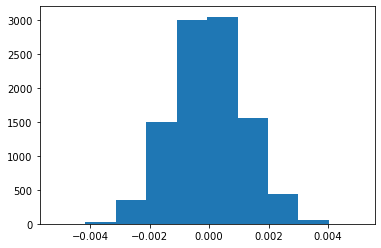

In [124]:
# Ploting a histogram of the p_diffs.
plt.hist(p_diffs);

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [125]:
obs_diff=df2.query('group=="treatment"').converted.mean()-df2.query('group=="control"').converted.mean()
obs_diff

-0.0015782389853555567

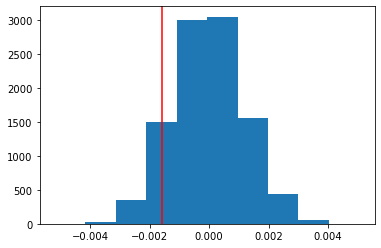

In [126]:
plt.hist(p_diffs);
plt.axvline(obs_diff,color="red");

In [127]:
(p_diffs > obs_diff).mean()

0.8986

The proportion of the simulated p_diffs values that are greater than the actaual difference observed in obs_diff is 90.5%.
this is also called the p-value, and it means that we can't reject the null value since it's a large number.

l. We could also use a built-in to achieve similar results.  The following Cells use statsmodel to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [128]:
import statsmodels.api as sm

n_new = len(df2.query('landing_page == "new_page"'))
n_old = len(df2.query('landing_page == "old_page"'))
convert_new = len(df2.query('landing_page == "new_page" & converted == True'))
convert_old = len(df2.query('landing_page == "old_page" & converted == True'))

using `stats.proportions_ztest` to compute your test statistic and p-value.

In [129]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)

In [130]:
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

These values mean that we can't reject the null hypothesis, since the p-value is larger than the signicance errorequal to 0.05.

<a id='regression'></a>
### Part III - A regression approach
Since each row is either a conversion or no conversion, Logistic resgression is the appropriate regression to perform.

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. However, I first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.

In [131]:
df2["intercept"]=1

In [132]:
df2[['control','treatment']]= pd.get_dummies(df2['group'])

In [133]:
df2.rename(columns={'treatment': 'ab_page'},inplace=True)
df2.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US,ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,1


Using **statsmodels** to instantiate your regression model on the two columns I created, then fitting the model using these two columns to predict whether or not an individual converts. 

In [134]:
model1 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result1=model1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


LinAlgError: Singular matrix

The following cell Provides a summary of the model.

In [101]:
from scipy import stats
stats.chisqprob = lambda chisq, df3: stats.chi2.sf(chisq, df3)
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Tue, 25 May 2021   Pseudo R-squ.:               8.085e-06
Time:                        12:52:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with ab_page is 0.19. It's higher than 0.05. Therefore, the coefficient is not significant.
in part II, the p-value was .90 while in this part it's .19 which is very different. in both cases we fail to reject the null hypothesis because the p-value is greater than the alpha level (type I error).  
It's a great idea to add other factors to spot other potential influence/s on the conversion rate. but the disadvantage would be the model becoming more complex.

adding an effect based on which country a user lives in. I will need to read in the **countries.csv** dataset and merge together my datasets on the appropriate rows.
Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion.  
I will first create the necessary additional columns (dummy variables), then fit the new model.  
Does it appear that country had an impact on conversion? 

In [103]:
# Joining the "countries" table.
countries_df = pd.read_csv('countries.csv')
df2 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [105]:
# Checking 
df2.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


Which countries users are from?

In [107]:
df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [109]:
# Creating dummy variables
df2[['CA','UK', 'US']]= pd.get_dummies(df2['country'])

In [111]:
df2.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [113]:
# Creating the model, fitting it and providing the summary
model2 = sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','US']])
results2 = model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 May 2021   Pseudo R-squ.:               2.323e-05
Time:                        12:52:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

By observing the p-values, The country doesn't influence the convertion rate, since all p-values are greater than 0.05, although CA is close, but it's still larger.

# Summary and conclusion:

There is no enough evidence that the new page is getting greater conversion rate than the old one. I couldn't reject the null hypothesis using propability, A/B testing, or logistic regression, therefore I think the company should focus on enhancing the old page or developing another new page.